# Hedonic prices in Busan

In [1]:
import esda
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterpolate
from libpysal import graph
from sklearn import ensemble, metrics, model_selection
from sklearn.linear_model import LinearRegression
import contextily

### 1. Load the data and convert it to a geodataframe, make sure you have the correct local projection.

In [2]:
# Load the data
prices = pd.read_csv('prices_data')
prices.head()

,Property Prices,Longitude,Latitude,Size,Floor,Highest floor,Units,Parking,Heating,Year,Dist. Green,Dist. Water,Green Index,Dist. Subway,Bus Stop,Dist. CBD,Top Univ.,High School,hex_id
0,9.798127,129.108144,35.215019,45.0700,8,13.0,84.0,0.67,0,2017,4.668050,7.092015,10.867812,5.655021,5,19909.899039,0,2,8730c1608ffffff
1,9.961756,129.022747,35.156333,51.5825,9,11.0,8.0,1.00,0,2018,5.056377,7.047563,11.906498,6.289145,6,19863.579251,0,2,8730c16adffffff
2,9.903488,129.094945,35.138296,61.5000,2,4.0,9.0,1.00,0,2015,8.030957,8.190858,10.548533,6.648096,13,19872.155922,0,2,8730c16f1ffffff
3,9.740969,128.958967,35.107674,70.3900,8,10.0,18.0,1.00,0,2012,8.030957,8.190858,9.683403,6.939003,13,19872.155922,0,2,8730c1684ffffff
4,9.769956,128.983673,35.138944,59.8200,28,29.0,416.0,0.62,0,1997,8.030957,8.190858,6.900350,7.837869,13,19872.155922,0,2,8730c16a1ffffff


The `prices` DataFrame contains columns with Latitude and Longitude, but no geometry. First we need to create a GeoDataFrame from the `prices` DataFrame. The `geometry` column should contain the Point objects created from the Latitude and Longitude columns. Be careful to assign correct local coordinate system to the GeoDataFrame. 



In [3]:
# Read as geodataframe
prices = gpd.GeoDataFrame(
    prices,
    geometry=gpd.points_from_xy(
        prices["Longitude"], prices["Latitude"], crs="EPSG:4326"
    ),
)

In [4]:
# Estimate and assign UTM CRS
crs_prices = prices.estimate_utm_crs()
prices = prices.to_crs(crs_prices)
prices.head()

,Property Prices,Longitude,Latitude,Size,Floor,Highest floor,Units,Parking,Heating,Year,Dist. Green,Dist. Water,Green Index,Dist. Subway,Bus Stop,Dist. CBD,Top Univ.,High School,hex_id,geometry
0,9.798127,129.108144,35.215019,45.0700,8,13.0,84.0,0.67,0,2017,4.668050,7.092015,10.867812,5.655021,5,19909.899039,0,2,8730c1608ffffff,POINT (509842.437 3896893.634)
1,9.961756,129.022747,35.156333,51.5825,9,11.0,8.0,1.00,0,2018,5.056377,7.047563,11.906498,6.289145,6,19863.579251,0,2,8730c16adffffff,POINT (502071.746 3890380.261)
2,9.903488,129.094945,35.138296,61.5000,2,4.0,9.0,1.00,0,2015,8.030957,8.190858,10.548533,6.648096,13,19872.155922,0,2,8730c16f1ffffff,POINT (508649.287 3888383.865)
3,9.740969,128.958967,35.107674,70.3900,8,10.0,18.0,1.00,0,2012,8.030957,8.190858,9.683403,6.939003,13,19872.155922,0,2,8730c1684ffffff,POINT (496260.582 3884984.578)
4,9.769956,128.983673,35.138944,59.8200,28,29.0,416.0,0.62,0,1997,8.030957,8.190858,6.900350,7.837869,13,19872.155922,0,2,8730c16a1ffffff,POINT (498512.657 3888451.725)


### 2. The target variable is ‘Property Prices’. Choose at least five independent variables that you think will be good predictors of the target variable.

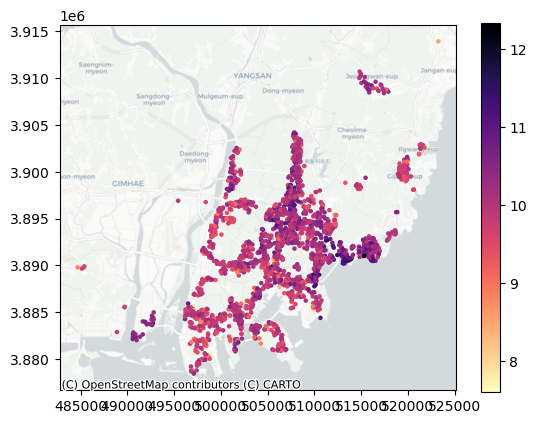

In [5]:
# Plot the target variable
ax = prices.plot(
    'Property Prices',
    legend=True,
    vmin=prices['Property Prices'].min(),
    vmax=prices['Property Prices'].max(),
    cmap='magma_r',
    markersize=5,
)
contextily.add_basemap(ax=ax, crs=prices.crs, source="CartoDB Positron")

plt.show()

You have your target variable. The models will try to predict it based
on a set of independent variables that you will choose. Let's pick the
following independent variables:

In [6]:
independent_variables = ['Size', 'Floor', 'Units', 'Parking', 'Dist. Green', 'Heating', 'Dist. Subway', 'Bus Stop', 'High School']

You can briefly check how each looks on a map and compare them to the
distribution of prices.

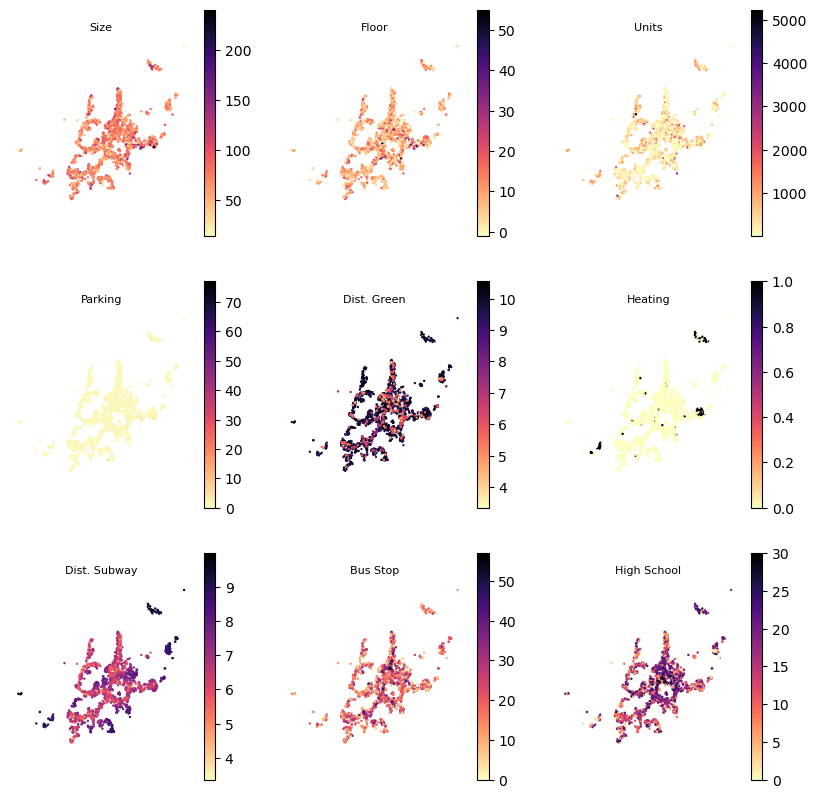

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for variable, ax in zip(independent_variables, axs.flatten()):
    prices.plot(
        variable,
        ax=ax,
        cmap="magma_r",
        legend=True,
        markersize=0.5
    )
    ax.set_title(variable, fontdict={"fontsize": 8})
    ax.set_axis_off()

In [8]:
# Prepare the data for the model
independent = prices[independent_variables]
target = prices['Property Prices']

### 3. Prepare you data for modeling - split it into training and testing sets.


In [9]:
# Split the data
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    independent, target, test_size=0.2, random_state=0
)
X_train.head()

,Size,Floor,Units,Parking,Dist. Green,Heating,Dist. Subway,Bus Stop,High School
768,75.9138,12,39.0,1.08,9.861707,0,6.749121,37,26
1492,84.4200,5,256.0,0.66,10.039642,0,6.530225,19,20
1581,64.3400,16,54.0,1.06,9.899372,0,4.699541,40,25
1587,58.1200,8,98.0,0.56,9.964188,0,8.829045,8,24
2371,84.7300,5,937.0,0.69,6.804496,0,7.105414,9,17


You can check that `X_*`, containing independent variables is split into
two parts, one with 80% of the data and the other with remaining 20%.
Completely randomly.

In [10]:
X_train.shape, X_test.shape

((1923, 9), (481, 9))

### 4. Try to fit a linear regression model and compare it with a tree based model of your choice, is there a difference?

In [11]:
linear_model = LinearRegression(n_jobs=-1)
linear_model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [12]:
pred_test_lin = linear_model.predict(X_test)

In [13]:
# Compute the evaluation metrics
r2 = metrics.r2_score(y_test, pred_test_lin)
mean_absolute_error = metrics.mean_absolute_error(y_test, pred_test_lin)
rmse = metrics.root_mean_squared_error(y_test, pred_test_lin)

# Print the summary
summary = f"""\
Evaluation metrics
==================
Linear regression:
  R2:   {round(r2, 3)}
  MAE:  {round(mean_absolute_error, 3)}
  RMSE: {round(rmse, 3)}
"""
print(summary)

Evaluation metrics
Linear regression:
  R2:   0.555
  MAE:  0.254
  RMSE: 0.322



In [14]:
# Train the random forest model
rf_model = ensemble.RandomForestRegressor(n_jobs=-1, random_state=0)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [15]:
# Predict the test set
pred_test_rf = rf_model.predict(X_test)

In [16]:
# Compute the evaluation metrics
r2 = metrics.r2_score(y_test, pred_test_rf)
mean_absolute_error = metrics.mean_absolute_error(y_test, pred_test_rf)
rmse = metrics.root_mean_squared_error(y_test, pred_test_rf)

# Print the summary
summary = f"""\
Evaluation metrics
==================
Random Forest:
  R2:   {round(r2, 3)}
  MAE:  {round(mean_absolute_error, 3)}
  RMSE: {round(rmse, 3)}
"""
print(summary)

Evaluation metrics
Random Forest:
  R2:   0.682
  MAE:  0.21
  RMSE: 0.272



You can see that the random forest model performs better. R2 is higher by more than 10% and both RMSE and MAE are lower.

### 5. Cross validate your model and evaluate its performance. Plot the residuals.


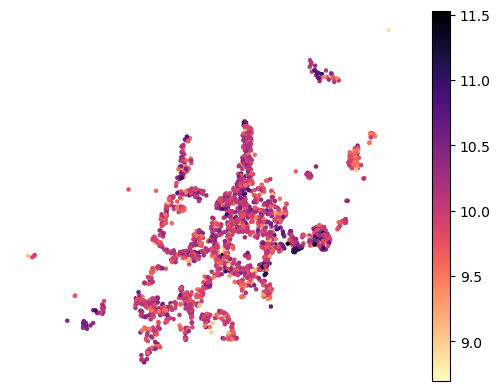

In [17]:
pred_cross_val = model_selection.cross_val_predict(
    rf_model,
    independent,
    target,
    n_jobs=-1,
)
prices.plot(pred_cross_val, legend=True, markersize = 5, cmap='magma_r').set_axis_off()

Cross-validation also allows you to assess the quality of the model more
reliably, minimising the effect of sampling on the metric. You can
simply measure the performance on the full array taking into account
every of the five folds.

In [18]:
r2_cross_val = metrics.r2_score(
    target, pred_cross_val
)
mae_cross_val = metrics.mean_absolute_error(
    target, pred_cross_val
)
rmse_cross_val = metrics.root_mean_squared_error(
    target, pred_cross_val
)

summary += f"""\
Random Forest (k-fold metrics):
  R2:   {round(r2_cross_val, 3)}
  MAE:  {round(mae_cross_val, 3)}
  RMSE: {round(rmse_cross_val, 3)}
"""
print(summary)

Evaluation metrics
Random Forest:
  R2:   0.682
  MAE:  0.21
  RMSE: 0.272
Random Forest (k-fold metrics):
  R2:   0.661
  MAE:  0.213
  RMSE: 0.279



These results are not wildly off but the performance dropped a bit. The
smaller the dataset (and this one is pretty small) the higher the effect
of train-test split could be. Let’s refer to the cross-validated metrics
as more reliable representation of the performance of the baseline model
here.

#### Residuals

Plot the residuals of the model to see if there is any pattern in
the errors.

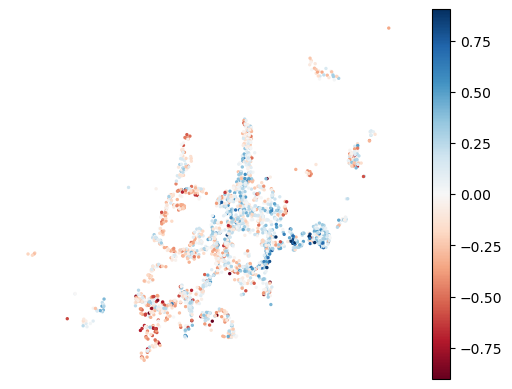

In [43]:
residuals = (target - pred_cross_val)

minmax = residuals.abs().std()
prices.plot(
    residuals,
    vmin=-minmax * 5,
    vmax=minmax * 5,
    cmap="RdBu",
    legend=True,
    markersize=2
).set_axis_off()

The over-predicted values are more common in the city center. The
under-predicted values are more common in the outskirts. 

### 6. Perform spatial evaluation using the "hex_id".


In [44]:
prices["prediction"] = pred_cross_val

Using `groupby`, you can group the data by `"hex_id"` and check the
metric within each one. 

In [21]:
grouped = prices.groupby("hex_id")[
    ["Property Prices", "prediction"]
]


block_mae = grouped.apply(
    lambda group: metrics.mean_absolute_error(
        group["Property Prices"], group["prediction"]
    )
)
block_rmse = grouped.apply(
    lambda group: metrics.root_mean_squared_error(
        group["Property Prices"], group["prediction"]
    )
)

Let’s concatenate them together to a single DataFrame with proper column
names.

In [22]:
spatial_metrics = pd.concat([block_mae, block_rmse], axis=1)
spatial_metrics.columns = ["block_mae", "block_rmse"]
spatial_metrics.head(3)

,block_mae,block_rmse
hex_id,,
8730c1280ffffff,0.346671,0.346671
8730c1296ffffff,0.187230,0.220848
8730c1600ffffff,0.248977,0.306339


And merge with the original data. The spatial metrics cannot be simply
assigned as new columns as they are much shorter - only one value per
*hex_id*. You need to merge on the *hex_id* values to assign it as new
columns.

In [23]:
prices = prices.merge(
    spatial_metrics, left_on="hex_id", right_index=True
)
prices.head(3)

,Property Prices,Longitude,Latitude,Size,Floor,Highest floor,Units,Parking,Heating,Year,...,Dist. Subway,Bus Stop,Dist. CBD,Top Univ.,High School,hex_id,geometry,prediction,block_mae,block_rmse
0,9.798127,129.108144,35.215019,45.0700,8,13.0,84.0,0.67,0,2017,...,5.655021,5,19909.899039,0,2,8730c1608ffffff,POINT (509842.437 3896893.634),9.766011,0.156624,0.209911
1,9.961756,129.022747,35.156333,51.5825,9,11.0,8.0,1.00,0,2018,...,6.289145,6,19863.579251,0,2,8730c16adffffff,POINT (502071.746 3890380.261),9.942710,0.196607,0.229704
2,9.903488,129.094945,35.138296,61.5000,2,4.0,9.0,1.00,0,2015,...,6.648096,13,19872.155922,0,2,8730c16f1ffffff,POINT (508649.287 3888383.865),9.920887,0.295113,0.371561


### 7. Compare blocked spatial metrics based on "hex_id" with the smoothed spatial metrics using graph.

Let’s see how the performance differs across space.

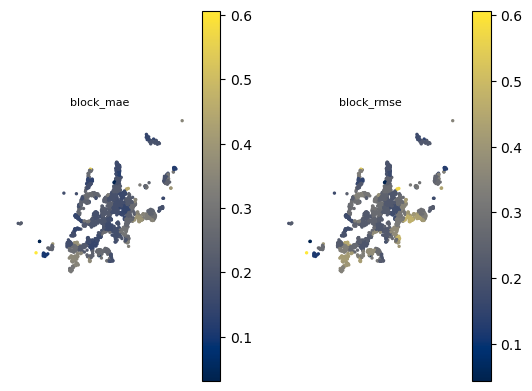

In [24]:
fig, axs = plt.subplots(1, 2)
for i, metric in enumerate(["block_mae", "block_rmse"]):
    prices.plot(metric, ax=axs[i], legend=True, cmap="cividis", markersize=2)
    axs[i].set_title(metric, fontdict={"fontsize": 8})
    axs[i].set_axis_off()

The spatial variation is evident. The model performs better in some
areas and worse in others. 

Another option is to measure the spatial metrics using the `Graph`.
In this case, you can assume that the price of a property in a given location
is influenced by the prices in neighbouring locations. The
so let’s get neighbors in the 1000m radius.


In [25]:
distance_band = graph.Graph.build_distance_band(
    prices, 1000
).assign_self_weight()

prices["spatial_mae"] = distance_band.apply(
    prices[["Property Prices", "prediction"]],
    lambda df: metrics.mean_absolute_error(
        df["Property Prices"], df["prediction"]
    ),
)
prices["spatial_rmse"] = distance_band.apply(
    prices[["Property Prices", "prediction"]],
    lambda df: metrics.root_mean_squared_error(
        df["Property Prices"], df["prediction"]
    ),
)

You can map the results again, observing much smoother transitions
between low and high values.

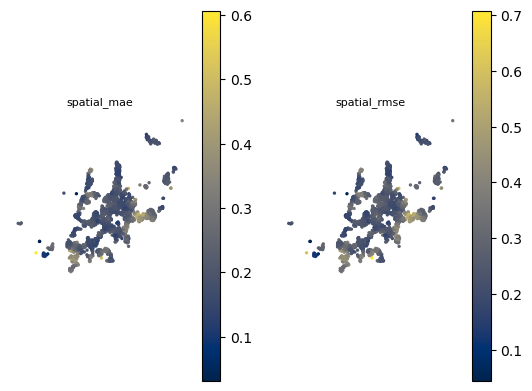

In [26]:
fig, axs = plt.subplots(1, 2)
for i, metric in enumerate(["spatial_mae", "spatial_rmse"]):
    prices.plot(metric, ax=axs[i], legend=True, cmap="cividis", markersize=2)
    axs[i].set_title(metric, fontdict={"fontsize": 8})
    axs[i].set_axis_off()

### 8. Check the spread of the asummed auotocorrelation using variogram.


In [27]:
input_data = np.hstack(
    [
        prices.get_coordinates(),
        residuals.abs().values.reshape(-1, 1),
    ]
)

Build the variogram, ideally covering the width of the whole city.

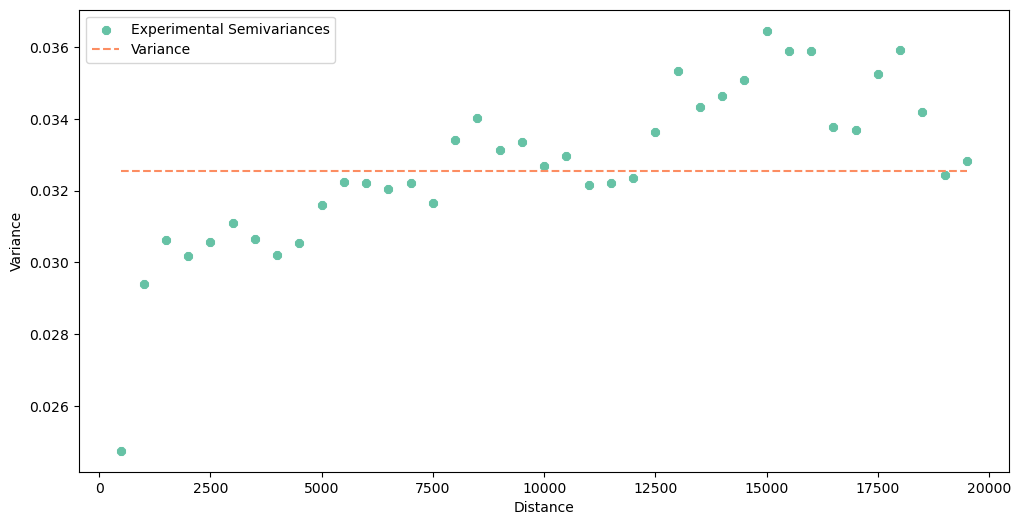

In [28]:
exp_semivar = pyinterpolate.build_experimental_variogram(
    input_array=input_data,
    step_size=500,
    max_range=20000,
)
exp_semivar.plot(plot_covariance=False)

The semivariance tends to grow nearly across the whole range, indicating
that the autocorrelation does not disappear when considering larger
distances. The results clearly suggests
that the model has a troubles with spatial heterogeneity of the
relationship between independent variables and the target one.

### 9. Perform LISA on the residuals - locate underpriced and overpriced properties, and clusters of consistently correct and consistently wrong locations.

One approach of determining spatial dependence of the residuals you are
already familiar with is measuring local indicators of spatial
autocorrelation. The variogram does not really help us in selecting the
optimal neighborhood to work with, so let’s build a distance band graph
with the threshold of 1 km.

In [29]:
distance_1km = graph.Graph.build_distance_band(
    prices, 1000
)

In [30]:
# Under-predicted and over-predicted
moran = esda.Moran_Local(residuals, distance_1km, permutations=9999, seed=0)
moran.explore(prices, tiles = "CartoDB dark_matter")

/Users/annabrazdova/default/phd/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1084: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


High-High clusters are those that are consistently under-predicted while Low-Low are those consistently over-predicted based on the spatial distribution of residuals.

In [31]:
# clusters of consistently correct and consistently wrong locations.
moran_abs = esda.Moran_Local(residuals.abs(), distance_1km, permutations=9999, seed=0)
moran_abs.explore(prices, tiles="CartoDB dark_matter")

/Users/annabrazdova/default/phd/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1084: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


This time, High-High captures clusters of high error rates, while
Low-Low areas of low error rate.

### 10. Build a model which avoids spatial leakage using the "hex_id" and tune its hyperparameters. 
- Is the performace different from the previous models? 
- Which features are important in this model?


In [32]:
for variable in independent_variables + ["Property Prices"]:
    morans_i = esda.Moran(prices[variable], distance_band)
    print(f"Moran's I of {variable} is {morans_i.I:.2f} with the  p-value of {morans_i.p_sim}.")

Moran's I of Size is 0.12 with the  p-value of 0.001.
Moran's I of Floor is 0.10 with the  p-value of 0.001.
Moran's I of Units is 0.21 with the  p-value of 0.001.
Moran's I of Parking is 0.02 with the  p-value of 0.405.
Moran's I of Dist. Green is 0.05 with the  p-value of 0.012.
Moran's I of Heating is 0.51 with the  p-value of 0.001.
Moran's I of Dist. Subway is 0.74 with the  p-value of 0.001.
Moran's I of Bus Stop is 0.06 with the  p-value of 0.001.
Moran's I of High School is 0.09 with the  p-value of 0.001.
Moran's I of Property Prices is 0.25 with the  p-value of 0.001.


Some of the variables are spatially more or less autocorrelated, which means that
there is a risk of spatial leakage.

Spatial cross-validation mitigates the issue by including a spatial
dimension in the train-test split. The aim is to divide the whole study
area into smaller regions and allocate whole regions to train and test
splits. 

Instead of using `KFold`, use `GroupKFold`, which ensures that
observations are allocated into splits by groups (all observations
within a single group will be in a single split).

In [34]:
independent_hex = prices[independent_variables + ["hex_id"]]

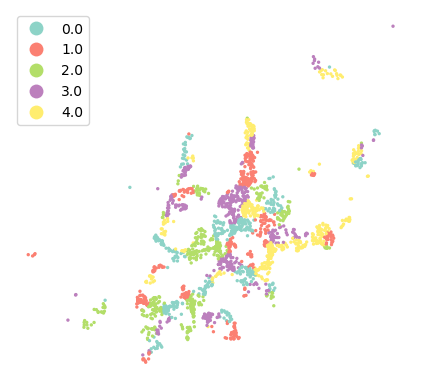

In [35]:
gkf = model_selection.GroupKFold(n_splits=5)
splits = gkf.split(
    independent,
    groups=independent_hex["hex_id"]
)
split_label = np.empty(len(independent), dtype=float)
for i, (train, test) in enumerate(splits):
    split_label[test] = i

prices.plot(
    split_label, categorical=True, legend=True, cmap="Set3",markersize=2
).set_axis_off()

Cross-validated prediction can then be performed using these splits,
ensuring that the spatial leakage between test and train is limited in
each fold.

In [36]:
rf_spatial_cv = ensemble.RandomForestRegressor(random_state=0, n_jobs=-1)

pred_spatial_cv = model_selection.cross_val_predict(
    rf_spatial_cv,
    independent,
    target,
    groups=prices["hex_id"],
    cv=gkf,
    n_jobs=-1,
)

The rest can follow the same pattern.

In [37]:
r2_spatial_cv = metrics.r2_score(target, pred_spatial_cv)
mae_spatial_cv = metrics.mean_absolute_error(target, pred_spatial_cv)
rmse_spatial_cv = metrics.root_mean_squared_error(target, pred_spatial_cv)

summary += f"""\
Random Forest with spatial cross-validation (k-fold):
  R2:   {round(r2_spatial_cv, 3)}
  MAE:  {round(mae_spatial_cv, 3)}
  RMSE: {round(rmse_spatial_cv, 3)}
"""
print(summary)

Evaluation metrics
Random Forest:
  R2:   0.682
  MAE:  0.21
  RMSE: 0.272
Random Forest (k-fold metrics):
  R2:   0.661
  MAE:  0.213
  RMSE: 0.279
Random Forest with spatial cross-validation (k-fold):
  R2:   0.655
  MAE:  0.213
  RMSE: 0.281



The models with spatial cross-validation usually show worse performance
than those with the random one but that is expected. The difference is
due to elimination of the spatial leakage and hence improving the
robustness of the model, meaning that on unseen data, it will perform
better (contrary to the change in the metrics).



#### Hyper-parameter tuning

When searching for an optimal model, you shall test different
hyper-parameters. Let’s stick to the random forest model and try to find
the optimal number of trees and the maximum features to consider when
looking for the best split.

In [38]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_features": ["sqrt", "log2"],
}

rf = ensemble.RandomForestRegressor(random_state=0)

grid_search = model_selection.GridSearchCV(
   rf, param_grid, cv=gkf
)
grid_search.fit(independent, target, groups=prices["hex_id"])

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]})


Let’s extract the mean test scores per each model and figure out which
parameters are the best in this case.

In [39]:
params = grid_search.cv_results_["params"]
mean_scores = grid_search.cv_results_["mean_test_score"]

grid_search_results = pd.DataFrame(params)
grid_search_results["mean_score"] = mean_scores
grid_search_results.sort_values("mean_score", ascending=False)

,max_features,n_estimators,mean_score
2,sqrt,300,0.644337
5,log2,300,0.644337
1,sqrt,200,0.643140
4,log2,200,0.643140
0,sqrt,100,0.640603
3,log2,100,0.640603


The best model seems to be the one with 300 trees and `sqrt` number of
features to consider, which is the default value for the random forest.

#### Feature importance

Get the best model from the grid search and explore the importance of
individual independent variables.

In [40]:
best_model = grid_search.best_estimator_

<Axes: >

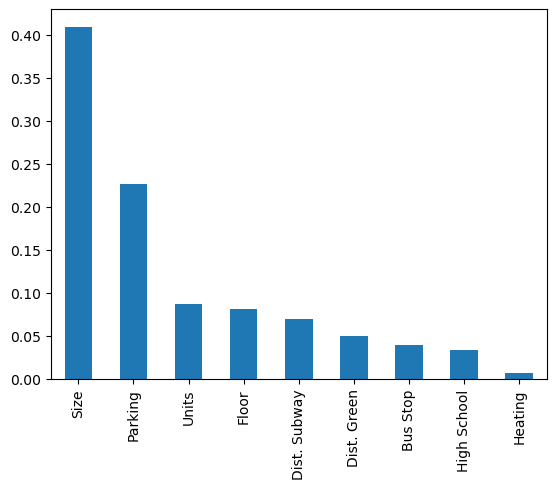

In [41]:
feature_importance = pd.Series(
    best_model.feature_importances_, index=independent_variables
)
feature_importance.sort_values(ascending=False).plot.bar()

The most important variable is the `Size` of the property, followed by
the `Parking` variable. The `Heating` variable is the least important.